<a href="https://colab.research.google.com/github/ksydata/HanaDT_SubProject/blob/main/DDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Open Dart API 인증키 번호
# api_key = "148723a5dc441466805520cde2aef20fd64cc5e7"

import pandas as pd
import io
import zipfile
from tqdm import tqdm

import requests
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ETREE
from typing import *
import statsmodels.api as sm

# from hmmlearn.hmm import GaussianHMM
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [12]:
class OpenDartDataCrawling():
# https://coding-moomin.tistory.com/5

  def __init__(self, api_key: str):
    self.api_key = api_key
      # certification key는 open dart api key를 나타내는 명칭


# getStockCode()
  def getStockCode(self, url: str) -> Any:
    parameters = {"crtfc_key": self.api_key}
    items = ["unique_code", "ticker_name", "stock_code", "modify_date"]
    item_names = ["고유번호", "회사명", "종목코드", "수정일"]

    response_url = requests.get(url, params = parameters)
    zfile = zipfile.ZipFile(io.BytesIO(response_url.content))
    open_zip_file = zfile.open(zfile.namelist()[0])
    decoding_root = ETREE.fromstring(open_zip_file.read().decode("utf-8"))

    stockcode_list: List = []
    for child in decoding_root:
      if len(child.find("stock_code").text.strip()) > 1:
        # 종목코드가 있는 경우에는(공백 제거 후 텍스트 길이가 1 초과하는 경우)
        stockcode_list.append([])
        # 리스트에 추가
        for item in items:
          stockcode_list[-1].append(child.find(item).text)

      stockcode_data = pd.DataFrame(
          stockcode_list, columns = item_names)
      return stockcode_data


# requestData()
  def requestData(self, url: str, items: List, item_names: List, params: Dict) -> Any:
    response_url = requests.get(url, params = params)
    json_data = response_url.json()
    json_dictionary = json.load(response_url.text)

    data: List = []
    if json_dictionary["status"] == "000":
      # 딕셔너리 키에 대한 값이 정상적으로 있다면
      # 응답키 status는 에러 및 정보 코드를 나타낸다.
      for line in json_dictionary["list"]:
        data.append([])
        for item in items:
          if item in line.keys():
            data[-1].append(line[item])
          else:
            data[-1].append("")
    items_data = pd.DataFrame(data, columns = item_names)
    return items_data


# getSingleFinancialSheet()
  def getSingleFinancialSheet(self,
                              url: str, items: List, item_names: List,
                              stock_code: str, business_year: str, report_code: str, YN: str) -> Any:
    parameters = {
        "crtfc_key":self.api_key,
        "corp_code":stock_code,
        "bsns_year":business_year,
        "reprt_code":report_code,
        "fs_div":YN}
    single_items_data = self.request(url = url, items = items, item_names = item_names, params = parameters)
    return single_items_data


In [13]:
loadData = OpenDartDataCrawling(api_key = "148723a5dc441466805520cde2aef20fd64cc5e7")

In [14]:
stock_code_dict = loadData.getStockCode(url = "https://opendart.fss.or.kr/api/corpCode.xml")

In [15]:
stock_code_dict

,고유번호,회사명,종목코드,수정일


In [ ]:
loadData.getSingleFinancialSheet(
    url = "https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json?",
    items = [
        "rcept_no","reprt_code","bsns_year","corp_code","sj_div","sj_nm",
        "account_id","account_nm","account_detail","thstrm_nm", "thstrm_amount",
        "thstrm_add_amount","frmtrm_nm","frmtrm_amount", "frmtrm_q_nm","frmtrm_q_amount",
        "frmtrm_add_amount","bfefrmtrm_nm", "bfefrmtrm_amount","ord"],
    item_names = [
        "접수번호","보고서코드","사업연도","고유번호","재무제표구분", "재무제표명",
        "계정ID","계정명","계정상세","당기명","당기금액", "당기누적금액","전기명","전기금액","전기명(분/반기)",
        "전기금액(분/반기)","전기누적금액","전전기명","전전기금액", "계정과목정렬순서"]
)

In [ ]:
"""
for k in tqdm(range(1, len(stock_code))):
  report_data = loadData.getSingleFin(crtfc_key, corp_code[k], 2020, '11013', fs_div = "CFS")
  final_report_data = pd.concat([final_reprt_df, reprt_df], axis = 0)
"""

경기 순환과 팩터, 섹터의 민감도(빈도수와 확률)
1. MSCI의 매크로 국면판단 투자전략
* 글로벌 경기선행지수(OECD, MSCI World Gross Index) : CLI MoM

  https://data.oecd.org/leadind/composite-leading-indicator-cli.htm
  
* MSCI World Sector Index 기준 유니버스
* 글로벌 소비자물가지수(CPI)의 단기과열 여부로 증감 판단(3개월 평균 CPI - 3년 평균 CPI) : 3M-3Y

* Heating Up : 경기선행지수 상승 / 인플레이션율 상승
* Goldilocks : 경기선행지수 상승 / 인플레이션율 하락
* Slow Growth : 경기선행지수 하락 / 인플레이션율 하락
* Stagflation : 경기선행지수 하락 / 인플레이션율 상승

* 매크로 데이터 수집 소스 : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part9_Macro_Indicators_vs_Stock_Indexes_Growth.ipynb

* 팩터 투자 소스 : https://hyunyulhenry.github.io/quant_cookbook/%ED%80%80%ED%8A%B8-%EC%A0%84%EB%9E%B5%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%A2%85%EB%AA%A9%EC%84%A0%EC%A0%95-%EA%B8%B0%EB%B3%B8.html#%EB%AA%A8%EB%A9%98%ED%85%80-%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4-%EA%B5%AC%ED%95%98%EA%B8%B0-%EC%9C%84%ED%97%98%EC%A1%B0%EC%A0%95-%EC%88%98%EC%9D%B5%EB%A5%A0

* Asset Pricing : https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1996.tb05202.x

* Dynamic Investment Appraisal : https://www.sciencedirect.com/topics/economics-econometrics-and-finance/dynamic-investment-appraisal

* 벤치마크 지수(FnGuide) : http://www.fnindex.co.kr/overview/detail/I/FI00.WLT.SMV

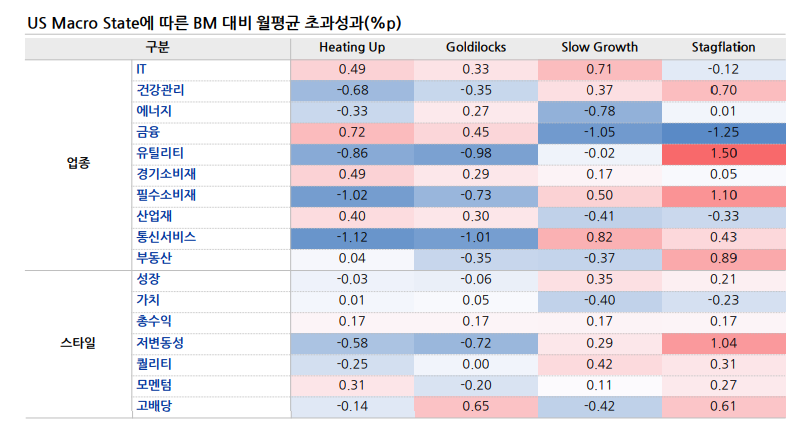
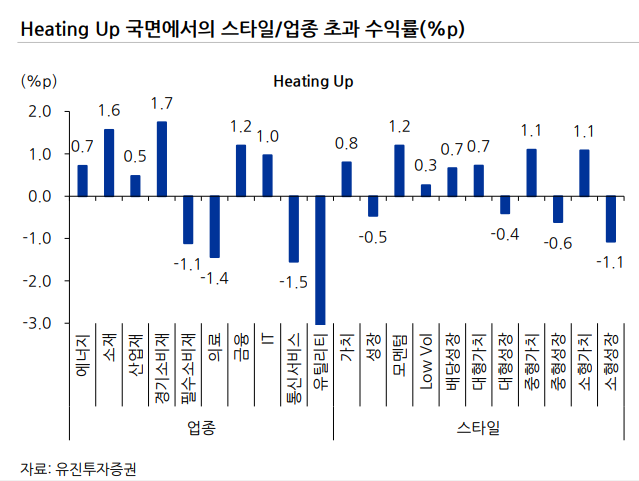

##### 2.Lakonishok, Shleifer Vishny 10분위수 이중정렬 포트폴리오

##### 3. Markov-Switching Dynamic Regression Models
(Hidden: 관측되지 않은 Markov Models: 마코프 모형)

* 순차데이터를 확률적으로 모델링하는 생성모델
State로 이루어진 Sequence를 상태 전이확률 행렬로 표현한 것을 말한다.

* Markov 가정 : 시간 t에서의 관측은 가장 최근 r개의 관측에만 의존한다는 전제를 두고 있다. 한 상태에서 다른 상태로의 전이는 이전 상태의 긴 이력을 필요치 않다는 가정이다.

  * First Order Markov Model : If $ r = 1, p(S_t|S_{t-1}, S_{t-2}, \cdots, S_1) = p(S_t|S_{t-1}) $
  
  * Second Order Markov Model : IF $ r = 2,  p(S_t|S_{t-1}, S_{t-2}, \cdots, S_1) = p(S_t|S_{t-1}, S_{t-2}) $

* Parameters of the Markov model(상태전이확률행렬 $A(a_{ij})$), Matrix Form과 Graph Form으로 표현한다.

* Hidden Markov Model에는 Hidden / Observable state sequence로 구분된다.
  
  특정인의 행동(쇼핑, 연구, 산책)에 따라 날씨 추측, DNA 염기서열(ACGT...)에 따른 어느 부분이 Gene인지 추측, 주어진 단어의 품사 추측 등에 활용된다.

  Parameters of a hidden Markov Model $\lambda(A, B, π)$ HMM 모형을 적합하는 데 있어 평가, 디코딩, 학습(parameter estimation)의 문제가 있다.

  * $A(a_{ij}$ : 상태전이확률행렬(숨겨진 확률)(State transition probability matrix)

  A는 HMM이 작동하는 도중 **다음 상태를 결정**하는 확률

  $a_{ij} = p(q_{t+1} = s_j|q_t = s_i) 1 <= i,j <= n $는 t시점에서 i에 있는 상태 조건이다가 t+1시점에서 j에 있는 상태일 **조건부 확률**을 나타내는 표현식이다.

  * $B(b_{jk}$ : 방출확률행렬(종속확률)(Emisstion probability matrix)

  B는 HMM이 어느 상태에 도달하였을 때, 그 상태에서 관측될 확률을 결정하는 종속확률이다.

  $b_j(v_k)$는 은닉상태 $b_j$에서 관측치 $v_k$가 도출될 확률을 말한다. $b_j(v_k) = P(o_t = v_k | q_t = s_j) \\ 1 <= j <= n, \\ 1 <= k <= m $

  * $π(π_i)$ : Initial state probability matrix

  $π$는 HMM을 가동시킬 때 어느 상태에서 시작할지 결정하는 즉, $s_i$에서 시작할 확률을 말한다.

  * Decoding Problem : Given HMM($λ^*$) and O, find the optimal hidden state sequence(S)

  EX) 어떤 사람의 삶을 HMM으로 적합할 때 그 사람이 오늘 산책, 내일 산책, 모레 연구, 글피 쇼핑할 확률을 O = ($o_1$ = 산책, $o_2$ = 산책, $o_2$ = 연구, $o_4$ = 산책) = ?으로 표현한다.

  총 상태 개수가 N, Sequence 길이가 T, 총 경우의 수 $N^T$


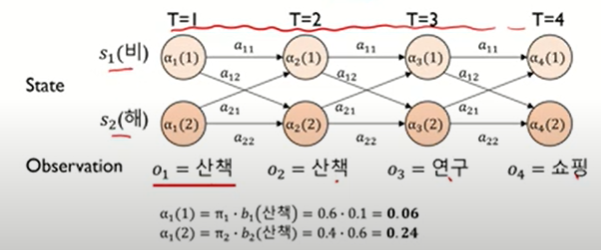

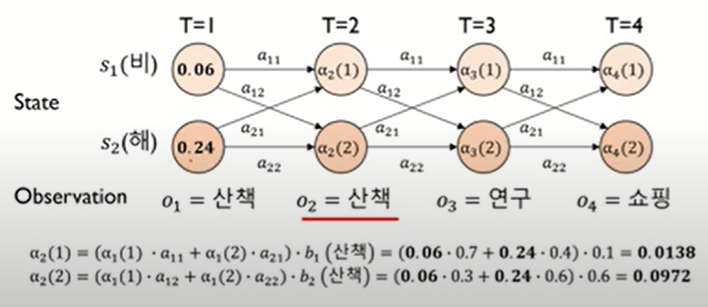

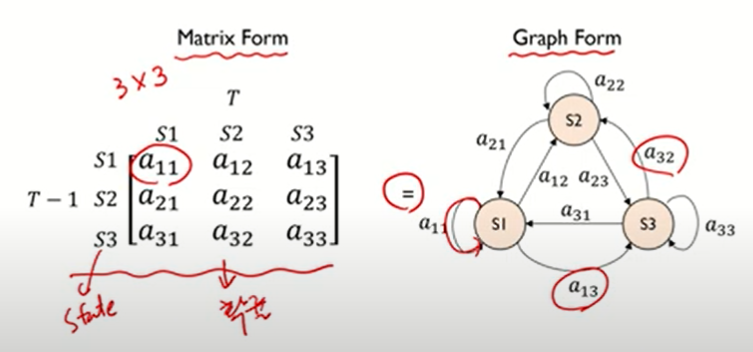

In [1]:
"""
# Step 1: Data Preparation
# Load historical data for securities and factors into DataFrames

# Step 2: Factor Selection

# Step 3: Factor Calculation
# Calculate factor values for each security

# Step 4: Rank Securities
# Rank securities based on each factor
ranked_securities = factor_values.rank(ascending = False)

# Step 5: Factor Weighting
# Assign weights to each factor
factor_weights = [0.4, 0.3, 0.3]

# Step 6: Portfolio Construction
# Combine rankings and weights to construct the portfolio
portfolio_ranking = ranked_securities.multiply(factor_weights).sum(axis = 1)
portfolio = portfolio_ranking.nlargest(10)
# Select top-ranked securities

# Step 7: Performance Evaluation
# Assess portfolio performance and monitor/rebalance as needed



# 데이터 준비
# 국면별로 분리된 데이터를 준비합니다. 각 국면에 대한 특징 데이터와 종속 변수를 포함해야 합니다.

# HMM 모델링
# HMM 모델을 생성하고 훈련합니다.
hmm_model = GaussianHMM(n_components=2)  # 국면의 수에 따라 조정
hmm_model.fit(training_data)

# 국면 예측
# 테스트 데이터를 사용하여 국면을 예측합니다.
predicted_states = hmm_model.predict(test_data)

# 국면별 모델링
models = []  # 국면별 모델을 저장할 리스트
for state in range(hmm_model.n_components):
    state_data = training_data[predicted_states == state]  # 해당 국면에 속하는 데이터 추출

    # 선형 회귀 모델링
    X = state_data[features]  # 특징 데이터
    y = state_data[target_variable]  # 종속 변수
    model = sm.OLS(y, sm.add_constant(X))  # 선형 회귀 모델 생성
    results = model.fit()  # 모델 훈련
    models.append(results)  # 모델 저장

# 예측
# 새로운 데이터를 사용하여 국면별 모델을 기반으로 예측 수행
new_data = pd.DataFrame(...)  # 예측할 새로운 데이터
predicted_values = []  # 예측 결과를 저장할 리스트
for state, model in enumerate(models):
    X_new = new_data[features]  # 특징 데이터
    X_new = sm.add_constant(X_new)
    predicted_values.append(model.predict(X_new))  # 예측 결과 저장

# 결과 분석 및 활용



# 데이터 준비
# 거시경제 지표와 팩터 데이터를 준비합니다.
macro_data = pd.DataFrame({
    'GDP_growth': [2.5, 1.8, 3.2, 0.5, 2.1],  # GDP 성장률 데이터
    'inflation_rate': [1.2, 1.5, 1.8, 1.3, 1.6]  # 인플레이션률 데이터
})

factor_data = pd.DataFrame({
    'factor1': [0.8, 1.2, 1.5, 0.9, 1.3],  # 팩터 1 데이터
    'factor2': [1.1, 1.4, 1.7, 0.7, 1.0]  # 팩터 2 데이터
})

returns = pd.DataFrame({
    'security1': [0.05, 0.02, 0.08, -0.03, 0.06],  # 증권1 수익률 데이터
    'security2': [0.03, 0.01, 0.06, -0.01, 0.04]  # 증권2 수익률 데이터
})

# 거시국면 및 팩터 모델링
# 팩터 모델을 구축하고 각 거시국면에 대한 회귀 모델을 훈련합니다.

# 거시국면 분류
# GDP 성장률과 인플레이션률을 기반으로 거시국면을 분류합니다.
macro_data['regime'] = np.where(macro_data['GDP_growth'] > 2.0, 'Expansion', 'Recession')

# 팩터 모델링
models = {}
for regime in macro_data['regime'].unique():
    regime_data = macro_data[macro_data['regime'] == regime]
    X = sm.add_constant(regime_data[['factor1', 'factor2']])
    y = returns.loc[regime_data.index]
    model = sm.OLS(y, X)
    result = model.fit()
    models[regime] = result

# 예측
# 새로운 거시경제 지표 값을 기반으로 거시국면 및 팩터 모델을 사용하여 수익률을 예측합니다.
new_macro_data = pd.DataFrame({
    'GDP_growth': [2.8, 1.6],
    'inflation_rate': [1.4, 1.7]
})

new_macro_data['regime'] = np.where(new_macro_data['GDP_growth'] > 2.0



# Load factor data
factor_data = pd.read_csv('factor_data.csv')

# Load returns data
returns_data = pd.read_csv('returns_data.csv')

# Define the target variable (e.g., stock returns)
target_variable = 'stock_returns'

# Define the factors to consider
factors = ['factor1', 'factor2', 'factor3']

# Define a threshold for factor selection
threshold = 0.1

selected_factors = []

# Perform factor selection
for factor in factors:
    factor_returns = factor_data[factor]
    factor_returns = factor_returns.dropna()

    # Calculate correlation between factor returns and target variable
    correlation = np.corrcoef(factor_returns, returns_data[target_variable])[0, 1]

    # Check if correlation exceeds the threshold
    if correlation > threshold:
        selected_factors.append(factor)

# Print selected factors
print("Selected factors:")
for factor in selected_factors:
    print(factor)


# investing.com에서 거시경제변수 데이터 URL
url = 'https://www.investing.com/economic-calendar/'

# HTTP GET 요청을 통해 HTML 데이터 가져오기
response = requests.get(url)
html_data = response.text

# BeautifulSoup을 사용하여 HTML 파싱
soup = BeautifulSoup(html_data, 'html.parser')

# 데이터 추출 및 가공
data_container = soup.find('table', {'id': 'economicCalendarData'})  # 데이터가 포함된 테이블 요소 찾기

# 테이블의 각 행(row)별로 데이터 추출
for row in data_container.find_all('tr'):
    # 각 행의 셀(cell)별로 데이터 추출
    cells = row.find_all('td')
    if len(cells) > 0:
        date = cells[0].text  # 날짜 정보
        event = cells[1].text  # 이벤트 정보
        impact = cells[2].text  # 영향도 정보
        actual = cells[3].text  # 실제값 정보
        forecast = cells[4].text  # 예측값 정보
        previous = cells[5].text  # 이전값 정보

        # TODO: 추출한 데이터를 원하는 형식으로 가공하여 저장 또는 활용
"""

'\n# Step 1: Data Preparation\n# Load historical data for securities and factors into DataFrames\n\n# Step 2: Factor Selection\n\n# Step 3: Factor Calculation\n# Calculate factor values for each security\n\n# Step 4: Rank Securities\n# Rank securities based on each factor \nranked_securities = factor_values.rank(ascending = False)\n\n# Step 5: Factor Weighting\n# Assign weights to each factor \nfactor_weights = [0.4, 0.3, 0.3]\n\n# Step 6: Portfolio Construction\n# Combine rankings and weights to construct the portfolio\nportfolio_ranking = ranked_securities.multiply(factor_weights).sum(axis = 1)\nportfolio = portfolio_ranking.nlargest(10)\n# Select top-ranked securities\n\n# Step 7: Performance Evaluation\n# Assess portfolio performance and monitor/rebalance as needed\n\n\n\n# 데이터 준비\n# 국면별로 분리된 데이터를 준비합니다. 각 국면에 대한 특징 데이터와 종속 변수를 포함해야 합니다.\n\n# HMM 모델링\n# HMM 모델을 생성하고 훈련합니다.\nhmm_model = GaussianHMM(n_components=2)  # 국면의 수에 따라 조정\nhmm_model.fit(training_data)\n\n# 국면 예측\n# 테스트 데이터를 